
# # Exploratory Data Analysis for CFPB Complaints

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
import os

# Add the project root (parent of src) to sys.path
sys.path.insert(0, os.path.abspath('..'))
from src.data_processing import clean_narrative

# %%
# Load raw data
df = pd.read_csv('../data/raw/complaints.csv', low_memory=False)
print(f"Original dataset shape: {df.shape}")


Original dataset shape: (9609797, 18)


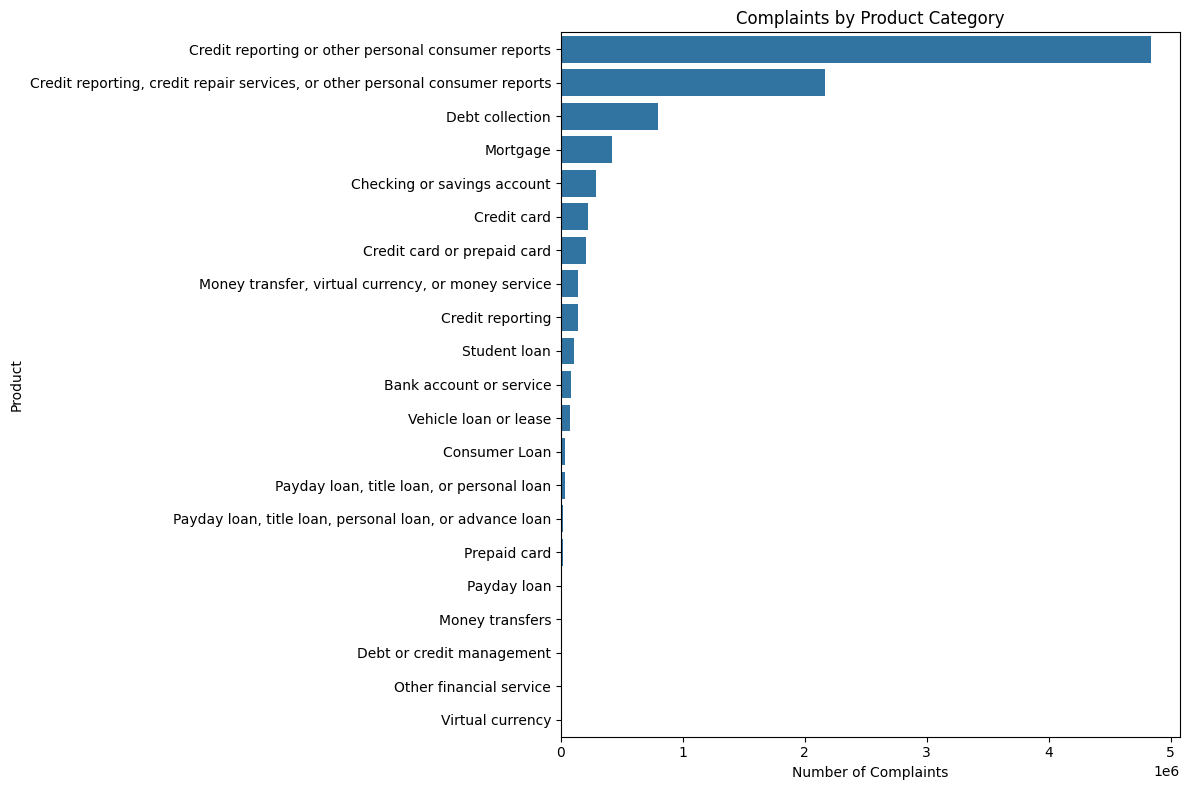

In [3]:

# Product distribution analysis
plt.figure(figsize=(12, 8))
product_counts = df['Product'].value_counts()
sns.barplot(x=product_counts.values, y=product_counts.index)
plt.title('Complaints by Product Category')
plt.xlabel('Number of Complaints')
plt.tight_layout()
plt.savefig('../docs/images/product_distribution.png')
plt.show()

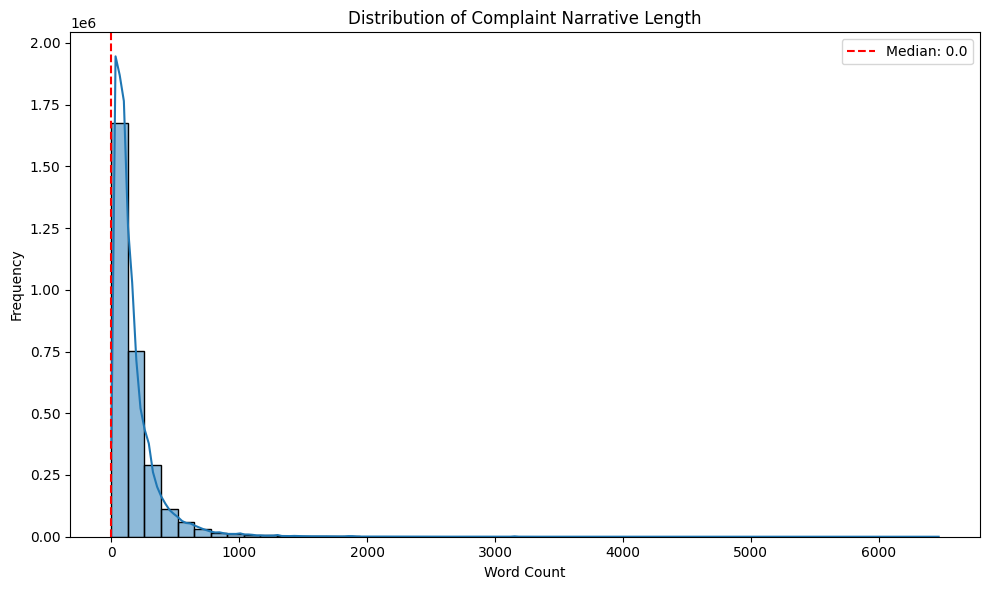

Narratives with 0 words: 6629041
Median length: 0.0 words
95th percentile: 282.0 words


In [7]:
# %%
# Narrative length analysis
df['narrative_length'] = df['Consumer complaint narrative'].apply(
    lambda x: len(str(x).split()) if pd.notnull(x) else 0
)

plt.figure(figsize=(10, 6))
sns.histplot(df[df['narrative_length'] > 0]['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(df['narrative_length'].median(), color='r', linestyle='--', label=f'Median: {df["narrative_length"].median()}')
plt.legend()
plt.tight_layout()
plt.savefig('../docs/images/narrative_length.png')
plt.show()

print(f"Narratives with 0 words: {len(df[df['narrative_length'] == 0])}")
print(f"Median length: {df['narrative_length'].median()} words")
print(f"95th percentile: {df['narrative_length'].quantile(0.95)} words")

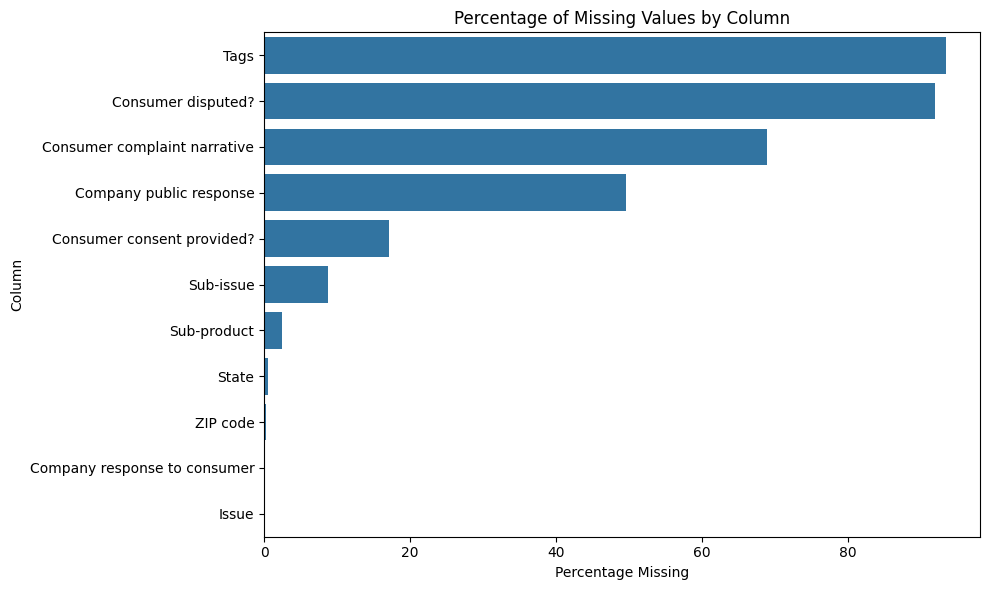

In [8]:
# %%
# Missing data analysis
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data['Percentage'] = (missing_data['Missing Count'] / len(df)) * 100
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Percentage', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage', y='Column', data=missing_data)
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Percentage Missing')
plt.ylabel('Column')
plt.tight_layout()
plt.savefig('../docs/images/missing_data.png')
plt.show()

In [9]:
# %%
# Text preprocessing example
sample_text = df['Consumer complaint narrative'].iloc[123]
print("Original Text:\n", sample_text)
print("\nCleaned Text:\n", clean_narrative(sample_text))

Original Text:
 nan

Cleaned Text:
 


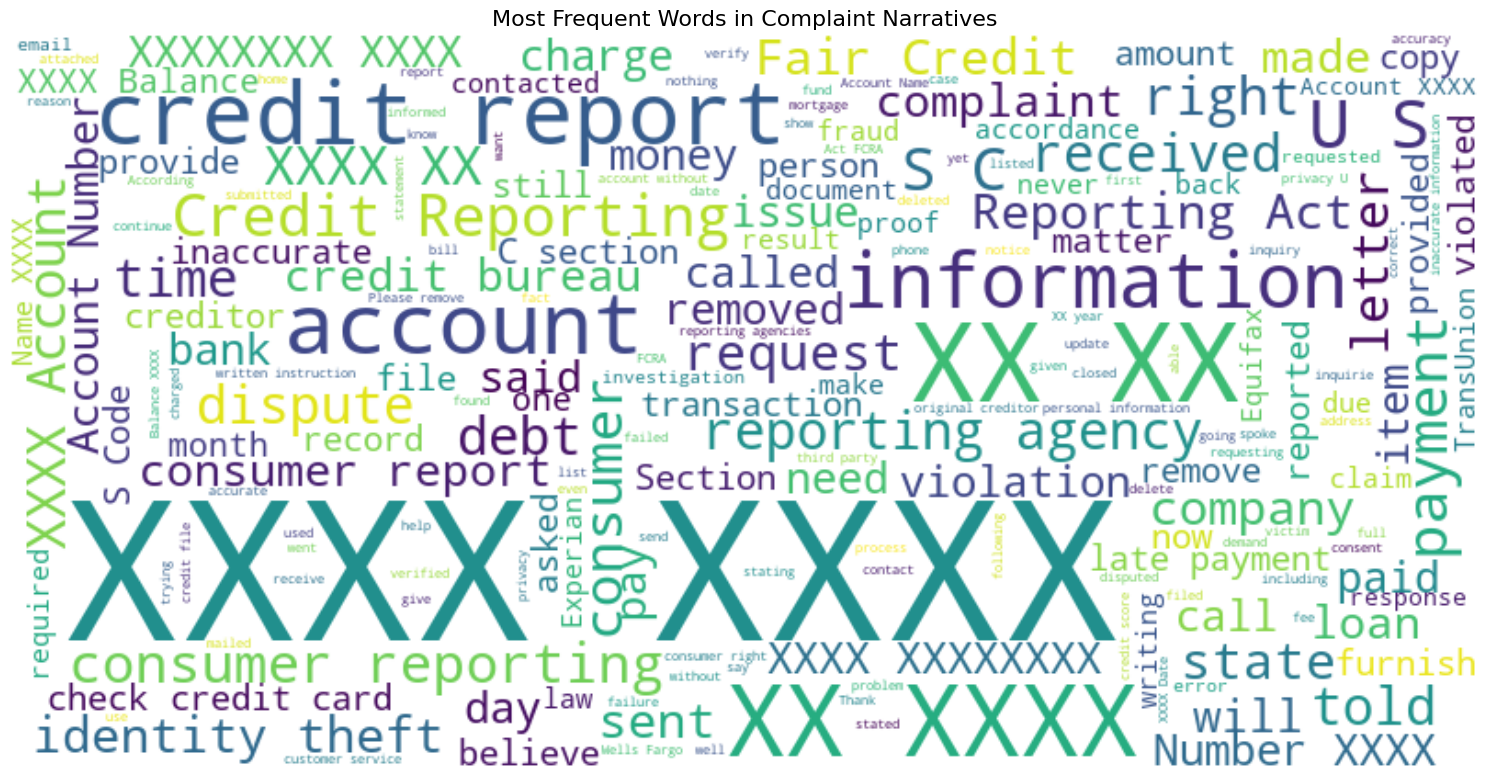

In [15]:
# %%
# Word cloud for most common issues (sampled to avoid MemoryError)
sample_narratives = df['Consumer complaint narrative'].dropna().astype(str)
sample_narratives = sample_narratives[sample_narratives.str.len() > 50]

# Sample up to 10,000 narratives for memory efficiency
if len(sample_narratives) > 10000:
    sample_narratives = sample_narratives.sample(10000, random_state=42)

text = " ".join(sample_narratives)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words in Complaint Narratives', fontsize=16)
plt.tight_layout()
plt.savefig('../docs/images/wordcloud.png')
plt.show()

In [16]:
# %%
# Save key statistics for report
stats = {
    "total_records": len(df),
    "products": product_counts.to_dict(),
    "missing_narratives": len(df[df['Consumer complaint narrative'].isna()]),
    "median_length": df['narrative_length'].median(),
    "top_5_issues": df['Issue'].value_counts().head(5).to_dict()
}

pd.DataFrame([stats]).to_json('../docs/eda_stats.json', orient='records')